# Programming exercise:
Unnormalized density given by: $\tilde{p}(x) := e^{-x^2/2} \left[sin(x)^2 + 3*cos(x)^2*sin(7*x)^2 + 1\right]$,  $-3 <= x <= 3$  
Task: Sample from this distribution and calculate $E(x^2)$.  
a: Try rejection sampling with a uniform proposal  
b: Try rejection sampling with a normal distribution  
c: Try self-normalized importance sampling with a gaussian proposal  
d: Try calculating it in Pyro using HMC or NUTS.  

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

In [8]:
def p_tilde(x):
    return np.exp(-x**2.0/2.0) * ((np.sin(x))**2.0+3.0*(np.cos(x))**2.0*(np.sin(7.0*x))**2.0+1.0)

### a: Try rejection sampling with a uniform proposal

Choose k:  
$\tilde{p}(x) \leq e^{0} \left[ 1 + 3 \cdot 1 \cdot 1 + 1 \right] = 5 $

In [9]:
k_unif = 5*6 # as the interval [-3,3] is 6 long

In [46]:
def rejection_sampling_uniform(n_samples = 5):    
    Z = []
    for i in range(n_samples):
        z = np.random.uniform(-3,3) # proposal
        u = np.random.uniform(0, k_unif*1/6) # u * k * q(z). Note that q(z)=1/6 for all z.
        if(u <= p_tilde(z)):
            Z.append(z)
        # if(z == 0):
        #     print(z)
        # if(z == 1):
        #     print(z)
    return(Z)

In [100]:
rej_samp_unif_results = rejection_sampling_uniform(10000) # sample 10,000 times

Estiamte for the second moment:

In [102]:
round(np.mean([w**2 for w in rej_samp_unif_results]), 3)

0.941

### b: Try rejection sampling with a normal distribution  

In [79]:
max_gauss = norm.pdf(0, scale=1.1)

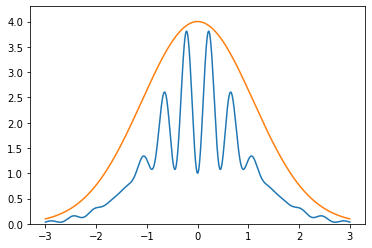

In [80]:
x = np.linspace(-3, 3, 10000)
plt.plot(x, p_tilde(x))
k_gauss = 4/max_gauss
plt.plot(x, norm.pdf(x, scale=1.1)*k_gauss)
plt.ylim(0,4.3)
plt.show()

In [81]:
def rejection_sampling_gaussian(n_samples = 5):
    Z = []
    for i in range(n_samples):
        z = np.random.normal(loc=0, scale=1.1)
        u = np.random.uniform(0, k_gauss*norm.pdf(z, loc=0, scale=1.1))
        if(u <= p_tilde(z)):
            Z.append(z)
    return(Z)

In [82]:
rej_samp_gauss_results = rejection_sampling_gaussian(10000) # sample 10,000 times

Estiamte for the second moment:

In [83]:
round(np.mean([w**2 for w in rej_samp_gauss_results]), 3)

0.923

### c: Try self-normalized importance sampling with a gaussian proposal  


In [18]:
def importance_sampling(n_samples = 5):
    Z = np.random.normal(scale=1.1, size=n_samples)
    r = [p_tilde(z)/norm.pdf(z, scale=1.1) for z in Z]
    W = r / np.sum(r)
    WfZ = [w * z**2 for w, z in zip(W, Z)]
    return(WfZ)

Estiamte for the second moment:

In [19]:
imp_res = importance_sampling(10000)
imp_second_moment = np.sum(imp_res)
round(imp_second_moment, 3)

0.942

### d: Try calculating it in Pyro using HMC or NUTS.  

In [1]:
import pyro
import torch
import pyro.distributions as pdist
import torch.distributions as tdist
import arviz
import numpy as np

We implement our own MyDensity class to specify the density we want to sample from.

In [2]:
# We need constraints to specify the integration interval
from torch.distributions import constraints


class MyDensity(pdist.TorchDistribution):
    # The integration interval
    support = constraints.interval(torch.tensor(-3), torch.tensor(3))
    # Constraint for the starting value used in the sampling 
    # (should be within integration interval)
    arg_constraints = {"start": support}

    def __init__(self, start=torch.tensor(0.0)):
      # start = starting value for HMC sampling, default 0
      self.start = start
      super(pdist.TorchDistribution, self).__init__()

    def sample(self, sample_shape=torch.Size()):
        # This is only used to start the HMC sampling
        # It simply returns the starting value for the sampling
        return self.start

    def log_prob(self, x):
        # Return log of the (unnormalized) density
        return -x**2.0/2.0 + torch.log( ((torch.sin(x))**2.0+3.0*(torch.cos(x))**2.0*(torch.sin(7.0*x))**2.0+1.0) )


In [3]:
# Specify the model, which in our case is just our MyDensity distribution

def model():
    x=pyro.sample("x", MyDensity())

In [4]:
# Run HMC / NUTS
nuts_kernel=pyro.infer.NUTS(model, jit_compile=True)
# jupyter notebook seems not to be able to do parallel, so I only use 1 chain in this example.
mcmc=pyro.infer.MCMC(nuts_kernel, num_samples=2000, num_chains=1, warmup_steps=500)
mcmc.run()

Sample: 100%|██████████| 2500/2500 [00:06, 367.95it/s, step size=1.60e-01, acc. prob=0.833]


In [5]:
# Get the samples
samples = mcmc.get_samples()["x"]

# Calculate E(x^2)
print(torch.mean(samples*samples).item())

1.13902747631073


Check the quality of the sampling (ESS, R-hat) and plot the empirical density with Arviz.

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.165  1.055  -2.152    1.968       0.09    0.065     143.0     116.0   

   r_hat  
x    NaN  


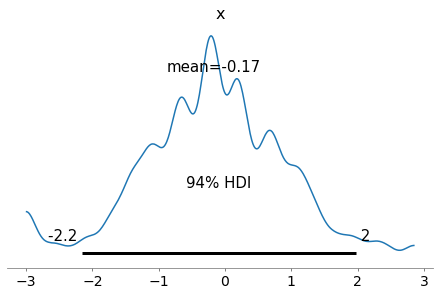

In [20]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print(summary) # because we only used one chain, r_hat cannot be evauated.
arviz.plot_posterior(data)
plt.show()

### e: Repeat the three methods for sample size 10, 100, and 1000. Plot the mean and standard deviation for each method and sample size in a single plot. Which method seems better?

In [21]:
def HMC(n_samples):
    # Run HMC / NUTS
    nuts_kernel=pyro.infer.NUTS(model, jit_compile=True)
    mcmc=pyro.infer.MCMC(nuts_kernel, num_samples=n_samples, num_chains=1, warmup_steps=0)
    mcmc.run()
    
    # Get the samples
    samples = mcmc.get_samples()["x"]

    # Calculate E(x^2)
    return(torch.mean(samples*samples).item())

In [22]:
samples_sizes = [10, 100, 1000]
K = 20
results = np.zeros((3,4,K))
for k in range(K):
    for i in range(3):
        n = samples_sizes[i]
        # for n = 10, we sometimes get no accepted samples with uniform proposal.
        res_uni = rejection_sampling_uniform(n)
        if(len(res_uni)>0):
            results[i,0,k] = np.mean([w**2 for w in res_uni])
        else:
            results[i,0,k] = 0
        results[i,1,k] = np.mean([w**2 for w in rejection_sampling_gaussian(n)])
        results[i,2,k] = np.sum(importance_sampling(n))
        results[i,3,k] = HMC(n)

Sample: 100%|██████████| 1000/1000 [00:03, 284.92it/s, step size=6.25e-02, acc. prob=0.968]


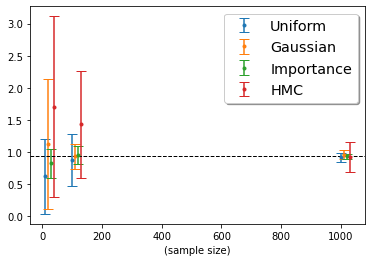

In [109]:
x = np.array([1, 10, 100])*10
y = np.mean(results[:,0,:], axis=1)
e = np.std(results[:,0,:], axis=1)
plt.errorbar(x, y, e, linestyle='None', marker='o', capsize=5, markersize=3, label='Uniform')

x = x + 10
y = np.mean(results[:,1,:], axis=1)
e = np.std(results[:,1,:], axis=1)
plt.errorbar(x, y, e, linestyle='None', marker='o', capsize=5, markersize=3, label='Gaussian')

x = x + 10
y = np.mean(results[:,2,:], axis=1)
e = np.std(results[:,2,:], axis=1)
plt.errorbar(x, y, e, linestyle='None', marker='o', capsize=5, markersize=3, label='Importance')

x = x + 10
y = np.mean(results[:,3,:], axis=1)
e = np.std(results[:,3,:], axis=1)
plt.errorbar(x, y, e, linestyle='None', marker='o', capsize=5, markersize=3, label='HMC')


plt.axhline(np.mean([np.mean(results[2,0,:]), np.mean(results[2,1,:]), np.mean(results[2,2,:])]), 
            c='black', linewidth=1, linestyle="--")
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.xlabel("(sample size)")
plt.show()

Importance sampling seem to be the best.  
HMC dosn't perform good compared to the others. This is probably because the samples in HMC are correlated, so the effective sample size is small. Also we only have one dimention and a fairly simple distribution $\tilde{p}$. Note also that the effective samples size between the different methods differ.